In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import re
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D, LSTM
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout, Activation, Flatten
from keras.models import Model
from keras.initializers import Constant
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from nltk.stem import PorterStemmer 
from nltk.tokenize import word_tokenize

from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *


# Use English stemmer.
word_stemmer = PorterStemmer()
wordnet_lemmatizer = WordNetLemmatizer()
from gensim.models.keyedvectors import KeyedVectors

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
!pip install keras==2.1.5

     |████████████████████████████████| 334 kB 39.5 MB/s 
  Attempting uninstall: keras
    Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%ls

8000-1.csv      california_housing_test.csv   mnist_test.csv         README.md*
anscombe.json*  california_housing_train.csv  mnist_train_small.csv


In [ ]:
real_news_df = pd.read_csv('sample_data/8000-1.csv')
fake_news_df = pd.read_csv('sample_data/fake_news_dataset_csv.csv', encoding= 'unicode_escape').dropna()
#real_news_df = real_news_df.rename(columns={"headline": "Article"})

In [ ]:
real_news_df['real_fact'] = 1
fake_news_df['real_fact'] = 0
print(real_news_df.shape)
print(fake_news_df.shape)

(8799, 6)
(8810, 6)


# Data cleaning

In [ ]:
def decontracted(phrase):
  # specific
  phrase = re.sub(r"won\'t", "will not", phrase)
  phrase = re.sub(r"can\'t", "can not", phrase)

  # general
  phrase = re.sub(r"n\'t", " not", phrase)
  phrase = re.sub(r"\'re", " are", phrase)
  phrase = re.sub(r"\'s", " is", phrase)
  phrase = re.sub(r"\'d", " would", phrase)
  phrase = re.sub(r"\'ll", " will", phrase)
  phrase = re.sub(r"\'t", " not", phrase)
  phrase = re.sub(r"\'ve", " have", phrase)
  phrase = re.sub(r"\'m", " am", phrase)
  return phrase



def get_cleaned_data(input_data, mode='df'):
  stop = stopwords.words('english')
  
  input_df = ''
  
  if mode != 'df':
      input_df = pd.DataFrame([input_data], columns=['Article'])
  else:
      input_df = input_data
      
  #lowercase the text
  input_df['Article'] = input_df['Article'].str.lower()
  
  input_df['Article'] = input_df['Article'].apply(lambda elem: decontracted(elem))
  
  #remove special characters
  input_df['Article'] = input_df['Article'].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem))
  
  # remove numbers
  input_df['Article'] = input_df['Article'].apply(lambda elem: re.sub(r"\d+", "", elem))
  
  #remove stopwords
  input_df['Article'] = input_df['Article'].apply(lambda x: ' '.join([word.strip() for word in x.split() if word not in (stop)]))
  
  #stemming, changes the word to root form
#     input_df['text'] = input_df['text'].apply(lambda words: [word_stemmer.stem(word) for word in words])
  
  #lemmatization, same as stemmer, but language corpus is used to fetch the root form, so resulting words make sense
#     more description @ https://www.datacamp.com/community/tutorials/stemming-lemmatization-python
  input_df['Article'] = input_df['Article'].apply(lambda words: (wordnet_lemmatizer.lemmatize(words)))
#     print(input_df.head(3))
  
  return input_df


In [ ]:
import nltk
nltk.download('wordnet')

fake_news_df = get_cleaned_data(fake_news_df)
real_news_df = get_cleaned_data(real_news_df)
news_data_df = pd.concat([real_news_df, fake_news_df], ignore_index = True)
print(news_data_df.shape)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
(17609, 9)


In [ ]:
news_data_df

,Unnamed: 0,Date,Article,Page_url,Source,real_fact,Country,News Type,Fact-Checked by
0,1.0,2020-04-05 23:59:42+00:00,british prime minister boris johnson hospitali...,https://www.complex.com/life/2020/04/boris-joh...,http://www.complex.com/,1,NaN,NaN,NaN
1,2.0,2020-04-05 23:59:36+00:00,nsw coronavirus death toll hits cases rise,https://www.sbs.com.au/news/nsw-coronavirus-de...,http://www.sbs.com.au/,1,NaN,NaN,NaN
2,3.0,2020-04-05 23:59:32+00:00,industry chandigarh need major impetus governm...,https://www.hindustantimes.com/chandigarh/indu...,http://www.hindustantimes.com/,1,NaN,NaN,NaN
3,4.0,2020-04-05 23:59:32+00:00,coronavirus chandigarh follow advisories one c...,https://www.hindustantimes.com/chandigarh/coro...,http://www.hindustantimes.com/,1,NaN,NaN,NaN
4,5.0,2020-04-05 23:59:32+00:00,crackers sound jarring note chandigarh tricity...,https://www.hindustantimes.com/chandigarh/crac...,http://www.hindustantimes.com/,1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
17604,NaN,1/21/2020,coronavirus created lab patented,NaN,NaN,0,"France, United States",FALSE,AFP
17605,NaN,1/21/2020,chinese market caused new coronavirus video,NaN,NaN,0,"Middle East, North Africa",Misleading,Misbar
17606,NaN,1/19/2020,peak new coronavirus happen two weeks jan two ...,NaN,NaN,0,Mexico,Partly FALSE,Animal Político
17607,NaN,1/18/2020,stores supermarkets veracruz mexico close due ...,NaN,NaN,0,Mexico,FALSE,Animal Político


In [ ]:
MAX_SEQUENCE_LENGTH = 500
MAX_NUM_WORDS = 10000
EMBEDDING_DIM = 300
VALIDATION_SPLIT = 0.2


x_train,x_test,y_train,y_test = train_test_split(news_data_df.Article,news_data_df.real_fact,random_state = 42, test_size=VALIDATION_SPLIT, shuffle=True)

# Word embedding

In [ ]:
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)

tokenizer.fit_on_texts(x_train)

# Transforms each text in texts to a sequence of integers. 
# So it basically takes each word in the text and replaces it with its corresponding integer value from the word_index dictionary.
# sequences = tokenizer.texts_to_sequences(news_data_df.text)
tokenized_train = tokenizer.texts_to_sequences(x_train)
X_train = pad_sequences(tokenized_train, maxlen=MAX_SEQUENCE_LENGTH)

word_index = tokenizer.word_index
print('Found {} unique tokens. and {} lines '.format(len(word_index), len(X_train)))

Found 16951 unique tokens. and 14087 lines 


In [ ]:
word_index

{'coronavirus': 1,
 'covid': 2,
 'people': 3,
 'new': 4,
 'lockdown': 5,
 'video': 6,
 'india': 7,
 'pandemic': 8,
 'cases': 9,
 'says': 10,
 'shows': 11,
 'times': 12,
 'virus': 13,
 'health': 14,
 'hospital': 15,
 'china': 16,
 'government': 17,
 'us': 18,
 'due': 19,
 'positive': 20,
 'news': 21,
 'facebook': 22,
 'claims': 23,
 'patients': 24,
 'home': 25,
 'president': 26,
 'outbreak': 27,
 'novel': 28,
 'vaccine': 29,
 'deaths': 30,
 'masks': 31,
 'amid': 32,
 'trump': 33,
 'claim': 34,
 'police': 35,
 'minister': 36,
 'infected': 37,
 'man': 38,
 'shared': 39,
 'social': 40,
 'death': 41,
 'quarantine': 42,
 'cure': 43,
 'state': 44,
 'pm': 45,
 'chinese': 46,
 'crisis': 47,
 'spread': 48,
 'photo': 49,
 'italy': 50,
 'tests': 51,
 'posts': 52,
 'said': 53,
 'died': 54,
 'city': 55,
 'fight': 56,
 'first': 57,
 'doctor': 58,
 'medical': 59,
 'image': 60,
 'one': 61,
 'two': 62,
 'indian': 63,
 'help': 64,
 'workers': 65,
 'post': 66,
 'water': 67,
 'wuhan': 68,
 'uk': 69,
 'face

In [54]:
tokenized_test = tokenizer.texts_to_sequences(x_test)
X_test = pad_sequences(tokenized_test, maxlen=MAX_SEQUENCE_LENGTH)

# Preparing embedding matrix

In [ ]:
vocab_size = len(tokenizer.word_index) + 1

# LSTM model

In [ ]:
def lstm_net1():
    model = Sequential()

    #Non-trainable embeddidng layer
    model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH, trainable=False))
    
    model.add(LSTM(units=128 , return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=64))
    model.add(Dropout(0.1))
    model.add(Dense(units = 32 , activation = 'relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [ ]:
#training an LSTM network
model2 = lstm_net1()

batch_size = 256
epochs = 8

model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 300)          5085600   
_________________________________________________________________
lstm (LSTM)                  (None, 500, 128)          219648    
_________________________________________________________________
dropout (Dropout)            (None, 500, 128)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 3

In [ ]:
history = model2.fit(X_train, y_train, batch_size = batch_size , validation_data = (X_test,y_test) , epochs = epochs)

Epoch 1/8
56/56 [==============================] - 35s 217ms/step - loss: 0.6778 - accuracy: 0.5744 - val_loss: 0.6098 - val_accuracy: 0.6465
Epoch 2/8
56/56 [==============================] - 11s 198ms/step - loss: 0.6022 - accuracy: 0.6521 - val_loss: 0.5782 - val_accuracy: 0.6985
Epoch 3/8
56/56 [==============================] - 11s 197ms/step - loss: 0.5492 - accuracy: 0.7044 - val_loss: 0.5160 - val_accuracy: 0.7271
Epoch 4/8
56/56 [==============================] - 11s 198ms/step - loss: 0.4948 - accuracy: 0.7528 - val_loss: 0.5057 - val_accuracy: 0.7411
Epoch 5/8
56/56 [==============================] - 11s 199ms/step - loss: 0.4919 - accuracy: 0.7555 - val_loss: 0.4756 - val_accuracy: 0.7646
Epoch 6/8
56/56 [==============================] - 11s 199ms/step - loss: 0.4619 - accuracy: 0.7712 - val_loss: 0.5562 - val_accuracy: 0.7132
Epoch 7/8
56/56 [==============================] - 11s 196ms/step - loss: 0.5059 - accuracy: 0.7487 - val_loss: 0.4562 - val_accuracy: 0.7842
Epoch 

# LSTM Confusion Matrix

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


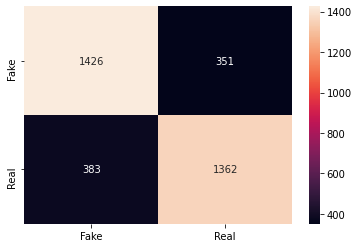

In [ ]:
pred = model2.predict_classes(X_test)
cf_matrix = confusion_matrix(y_test,pred)
sns.heatmap(cf_matrix, annot=True, fmt='g', xticklabels = ['Fake','Real'] , yticklabels = ['Fake','Real'])

In [ ]:
from sklearn.metrics import roc_auc_score

auc_score = roc_auc_score(y_test, pred)
print("AUC score is ", auc_score)

AUC score is  0.7914959212993794


In [ ]:
from sklearn.metrics import f1_score

F1_score = f1_score(y_test, pred, average='macro')
print("F1 score is", F1_score)

F1 score is 0.7915268457728903


In [ ]:
from sklearn.metrics import accuracy_score

accuracy_score = accuracy_score(y_test, pred)
print("Acuracy is ", accuracy_score)

Acuracy is  0.7915956842703009


# **CNN**

In [ ]:
def cnn_net1():
  model = Sequential()

  #Non-trainable embeddidng layer
  model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH, trainable=False))
  
  model.add(Dropout(0.2))
  model.add(Conv1D(filters=128, kernel_size=4, activation='relu'))
  model.add(GlobalMaxPooling1D())
  model.add(Dropout(0.2))
  model.add(Dense(units = 250 , activation = 'relu'))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  
  return model


def get_pred_output(text_to_check):
  sequences = tokenizer.texts_to_sequences([text_to_check])
  data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
  predicted_val = model.predict_classes(data)
#     predicted_val = model.predict(data)    
#     if predicted_val.max() > 0.7:
#         output = 1
#     else:
#         output = 0
  return predicted_val

In [ ]:
# train a 1D convnet with global maxpooling
model_1 = cnn_net1()

batch_size = 256
epochs = 8

model_1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 300)          5085600   
_________________________________________________________________
dropout_2 (Dropout)          (None, 500, 300)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 497, 128)          153728    
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 250)               32250     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [ ]:
history = model_1.fit(X_train, y_train, batch_size = batch_size , validation_data = (X_test,y_test) , epochs = epochs)

Epoch 1/8
56/56 [==============================] - 32s 107ms/step - loss: 0.6760 - accuracy: 0.5721 - val_loss: 0.5470 - val_accuracy: 0.7266
Epoch 2/8
56/56 [==============================] - 6s 101ms/step - loss: 0.5203 - accuracy: 0.7512 - val_loss: 0.4187 - val_accuracy: 0.8095
Epoch 3/8
56/56 [==============================] - 6s 100ms/step - loss: 0.3976 - accuracy: 0.8265 - val_loss: 0.3988 - val_accuracy: 0.8197
Epoch 4/8
56/56 [==============================] - 6s 100ms/step - loss: 0.3241 - accuracy: 0.8646 - val_loss: 0.3480 - val_accuracy: 0.8455
Epoch 5/8
56/56 [==============================] - 6s 100ms/step - loss: 0.2533 - accuracy: 0.8995 - val_loss: 0.3139 - val_accuracy: 0.8651
Epoch 6/8
56/56 [==============================] - 6s 100ms/step - loss: 0.2124 - accuracy: 0.9181 - val_loss: 0.3000 - val_accuracy: 0.8734
Epoch 7/8
56/56 [==============================] - 6s 100ms/step - loss: 0.1922 - accuracy: 0.9243 - val_loss: 0.3259 - val_accuracy: 0.8648
Epoch 8/8
56

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


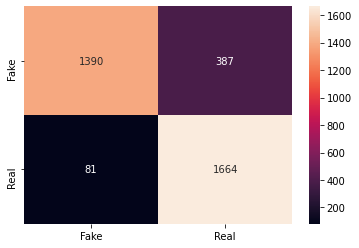

In [ ]:
pred = model_1.predict_classes(X_test)
cf_matrix = confusion_matrix(y_test,pred)
sns.heatmap(cf_matrix, annot=True, fmt='g', xticklabels = ['Fake','Real'] , yticklabels = ['Fake','Real'])

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

auc_score = roc_auc_score(y_test, pred)
print("AUC score is ", auc_score)

F1_score = f1_score(y_test, pred, average='macro')
print("F1 score is", F1_score)

accuracy_score = accuracy_score(y_test, pred)
print("Acuracy is ", accuracy_score)

AUC score is  0.8678994409624411
F1 score is 0.8663118294081922
Acuracy is  0.8671209540034072


# GloVe Embedding

In [ ]:
# load the GloVe embedding 
embeddings_index = dict()
f = open('/content/gdrive/My Drive/fake-news/glove.6B.300d.txt')
for line in f:
	values = line.split()
	word = values[0]
	coefs = np.asarray(values[1:], dtype='float32')
	embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

Loaded 400000 word vectors.


##LSTM

In [ ]:
def lstm_net1():
    model = Sequential()

    #Non-trainable embeddidng layer
    model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False))
    
    model.add(LSTM(units=128 , return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=64))
    model.add(Dropout(0.1))
    model.add(Dense(units = 32 , activation = 'relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [ ]:
#training an LSTM network
model2 = lstm_net1()

batch_size = 256
epochs = 8

model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 500, 300)          5085600   
_________________________________________________________________
lstm_2 (LSTM)                (None, 500, 128)          219648    
_________________________________________________________________
dropout_4 (Dropout)          (None, 500, 128)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [ ]:
history = model2.fit(X_train, y_train, batch_size = batch_size , validation_data = (X_test,y_test) , epochs = epochs)

Epoch 1/8
56/56 [==============================] - 15s 209ms/step - loss: 0.5258 - accuracy: 0.7133 - val_loss: 0.3219 - val_accuracy: 0.8668
Epoch 2/8
56/56 [==============================] - 11s 192ms/step - loss: 0.2812 - accuracy: 0.8843 - val_loss: 0.2753 - val_accuracy: 0.8884
Epoch 3/8
56/56 [==============================] - 11s 194ms/step - loss: 0.2364 - accuracy: 0.9022 - val_loss: 0.2933 - val_accuracy: 0.8805
Epoch 4/8
56/56 [==============================] - 11s 194ms/step - loss: 0.2264 - accuracy: 0.9050 - val_loss: 0.2326 - val_accuracy: 0.9094
Epoch 5/8
56/56 [==============================] - 11s 193ms/step - loss: 0.1693 - accuracy: 0.9334 - val_loss: 0.2188 - val_accuracy: 0.9160
Epoch 6/8
56/56 [==============================] - 11s 195ms/step - loss: 0.1404 - accuracy: 0.9471 - val_loss: 0.2747 - val_accuracy: 0.9055
Epoch 7/8
56/56 [==============================] - 11s 193ms/step - loss: 0.2111 - accuracy: 0.9207 - val_loss: 0.2187 - val_accuracy: 0.9191
Epoch 

In [ ]:
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score

pred = model2.predict_classes(X_test)
auc_score = roc_auc_score(y_test, pred)
F1_score = f1_score(y_test, pred, average='macro')
accuracy_score = accuracy_score(y_test, pred)

print("AUC score is ", auc_score)
print("F1 score is", F1_score)
print("Acuracy is ", accuracy_score)

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


AUC score is  0.9288077681550149
F1 score is 0.9287336683036287
Acuracy is  0.9287336740488359


##CNN

In [ ]:
def cnn_net1():
  model = Sequential()

  #Non-trainable embeddidng layer
  model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False))
  
  model.add(Dropout(0.2))
  model.add(Conv1D(filters=128, kernel_size=4, activation='relu'))
  model.add(GlobalMaxPooling1D())
  model.add(Dropout(0.2))
  model.add(Dense(units = 250 , activation = 'relu'))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  
  return model


def get_pred_output(text_to_check):
  sequences = tokenizer.texts_to_sequences([text_to_check])
  data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
  predicted_val = model.predict_classes(data)
#     predicted_val = model.predict(data)    
#     if predicted_val.max() > 0.7:
#         output = 1
#     else:
#         output = 0
  return predicted_val

In [ ]:
# train a 1D convnet with global maxpooling
model_1 = cnn_net1()

batch_size = 256
epochs = 8

model_1.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 500, 300)          5085600   
_________________________________________________________________
dropout_8 (Dropout)          (None, 500, 300)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 497, 128)          153728    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 128)               0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 250)               32250     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                

In [ ]:
history = model_1.fit(X_train, y_train, batch_size = batch_size , validation_data = (X_test,y_test) , epochs = epochs)

Epoch 1/8
56/56 [==============================] - 7s 109ms/step - loss: 0.6157 - accuracy: 0.6508 - val_loss: 0.3341 - val_accuracy: 0.8538
Epoch 2/8
56/56 [==============================] - 6s 102ms/step - loss: 0.3228 - accuracy: 0.8625 - val_loss: 0.2799 - val_accuracy: 0.8830
Epoch 3/8
56/56 [==============================] - 6s 101ms/step - loss: 0.2590 - accuracy: 0.8951 - val_loss: 0.2466 - val_accuracy: 0.8995
Epoch 4/8
56/56 [==============================] - 6s 101ms/step - loss: 0.2058 - accuracy: 0.9150 - val_loss: 0.2297 - val_accuracy: 0.9111
Epoch 5/8
56/56 [==============================] - 6s 101ms/step - loss: 0.1754 - accuracy: 0.9294 - val_loss: 0.2325 - val_accuracy: 0.9120
Epoch 6/8
56/56 [==============================] - 6s 101ms/step - loss: 0.1472 - accuracy: 0.9423 - val_loss: 0.2172 - val_accuracy: 0.9196
Epoch 7/8
56/56 [==============================] - 6s 101ms/step - loss: 0.1125 - accuracy: 0.9583 - val_loss: 0.2273 - val_accuracy: 0.9216
Epoch 8/8
56/

In [53]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

pred = model_1.predict_classes(X_test)

auc_score = roc_auc_score(y_test, pred)
print("AUC score is ", auc_score)

F1_score = f1_score(y_test, pred, average='macro')
print("F1 score is", F1_score)

accuracy_score = accuracy_score(y_test, pred)
print("Acuracy is ", accuracy_score)

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


AUC score is  0.9182266883595385
F1 score is 0.9182223460573977
Acuracy is  0.9182282793867121
